## Predictive Modeling: Cancer Mortality Forecasting

## 1. Preprocessing

**Goal:**

- Clean and align mortality data (2003–2015) by PHU

- Integrate SDOH (2016 or 2021 snapshot)

- Prepare structured dataset for both time-series and supervised regression forecasting

**Step 1: Import libralies**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline


c:\Users\AlexandreT2\miniconda3\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Step 2: Load all datasets**

In [1]:


import pandas as pd
import numpy as np

# Load dataframe CSVs 
mort = pd.read_csv("Cancer_Mortality_Snapshot_2003_2015.csv") # Cancer Mortality
inc = pd.read_csv("Cancer_Incidence_Snapshot_2010_2014.csv") # cancer incidence 
sdoh = pd.read_csv("SDOH_Clean_Wide.csv") 

# Inspect structure

print("Mortality data\n", mort.head())
print("Incidence data\n", inc.head())
print("SDOH data\n", sdoh.head())

Mortality data
                     Indicator                             Measure  Year  \
0  Mortality from all cancers  Age-standardized rate (both sexes)  2003   
1  Mortality from all cancers  Age-standardized rate (both sexes)  2004   
2  Mortality from all cancers  Age-standardized rate (both sexes)  2005   
3  Mortality from all cancers  Age-standardized rate (both sexes)  2006   
4  Mortality from all cancers  Age-standardized rate (both sexes)  2007   

              Geography   Rate 95% Confidence Interval  Count  Population  \
0  Algoma Public Health  254.5           (226.5-282.6)    330      120708   
1  Algoma Public Health  258.5           (231.1-285.9)    353      120353   
2  Algoma Public Health  262.0           (234.7-289.2)    367      120282   
3  Algoma Public Health  251.5           (225.0-278.0)    355      119936   
4  Algoma Public Health  225.4           (200.7-250.1)    328      119808   

  Significance Compared to Ontario  
0                               N

**Step 3: Data Filter and Cleaning**

From the mortality data set, we select the Age-standardized for both sexes and all cancers for simplicity. We are not treating sexes or cancer types separately. 

In [3]:
# Select the dataset of interest and some columns
mort_filtered = mort[(mort['Indicator'] == 'Mortality from all cancers') &
                     (mort['Measure'] == 'Age-standardized rate (both sexes)')].drop(columns= ['Indicator', 'Measure'] )

In [18]:
# Select the dataset of interest and some columns
inc_filtered = inc[(inc['Indicator'] == 'Incidence of all cancers') &
                     (inc['Measure'] == 'Age-standardized rate (both sexes)')].drop(columns= ['Indicator', 'Measure'] )

In [20]:

#Standardize column names
#Make sure variable names are consistent across datasets.
mort_filtered.rename(columns={
    "Geography": "PHU",
    "95% Confidence Interval": "95% CI MortalityRate",
    "Rate": "MortalityRate"
}, inplace=True)

inc_filtered.rename(columns={
    "Geography": "PHU",
    "Rate": "IncidenceRate",
     "95% Confidence Interval": "95% CI IncidenteRate",
}, inplace=True)

sdoh.rename(columns={
    "Geography": "PHU",
    'Per cent (%) immigrant population':'Immigrant rate', 
    'Per cent (%) lone parent households': 'Lone parent households rate', 
    'Per cent (%) of households spending more than 30% of their income on shelter costs' : 'Households spending more than 30%', 
    'Per cent (%) of the labour force population who are unemployed': 'Unemployed labour force rate', 
    'Per cent (%) of the population in the labour force (participation rate)': 'Participating labour force rate ', 
    'Per cent (%) of the population living in low income (LICO-AT) - Ages 0 to 17': '(LICO-AT) - Ages 0 to 17', 
    'Per cent (%) of the population living in low income (LICO-AT) - Ages 18 to 64': '(LICO-AT) - Ages 18 to 64', 
    'Per cent (%) of the population living in low income (LICO-AT) - Ages 65+':'(LICO-AT) - Ages 65+' , 
    'Per cent (%) of the population living in low income (LICO-AT) - All ages': '(LICO-AT) - All ages', 
    'Per cent (%) of the population living in low income (LIM-AT) - Ages 0 to 17': '(LIM-AT) - Ages 0 to 17', 
    'Per cent (%) of the population living in low income (LIM-AT) - Ages 18 to 64':'(LIM-AT) - Ages 18 to 64' , 
    'Per cent (%) of the population living in low income (LIM-AT) - Ages 65+' :' (LIM-AT) - Ages 65+', 
    'Per cent (%) of the population living in low income (LIM-AT) - All ages': '(LIM-AT) - All ages', 
    'Per cent (%) of the population who are employed':'Rate of employment',
    'Per cent (%) of the population who cannot speak English or French': 'Rate of no English or French speakers', 
    'Per cent (%) of the population with a high school diploma or post-secondary degree/diploma/certificate':'Rate of high school or post-secondary graduate', 
    'Per cent (%) of the population with a post-secondary degree/diploma/certificate': 'Rate of post-secondary graduate', 
    'Per cent (%) of the population without a high school diploma': 'Rate of no high school diploma holders', 
    'Per cent (%) recent immigrant population': 'Rate of recent immigrant', 
    'Per cent (%) senior population': 'Rate of Senior',
    'Per cent (%) visible minority population': ' Rate of visible minority'
 
}, inplace=True)

The SDOH dataset has only 2016 and 2021. We pick 2016 because it’s the most recent datasets available after the cancer mortality window (2003–2015) and cancer incidence (2010-2014), and using 2021 would be “future” socioeconomic data relative to the cancer outcomes.

In [21]:
#Filter the 2016 SDOH dataset
sdoh_2016 = sdoh[sdoh["Year"] == 2016]  # snapshot as lagged socioeconomic proxy

**Step 4: Check for missing values and duplicates**

In [7]:

print("Missing values:")
print(mort_filtered.isna().sum())
print(inc_filtered.isna().sum())
print(sdoh_2016.isna().sum())

print("Duplicates:")
print(mort_filtered.duplicated().sum(), inc_filtered.duplicated().sum(), sdoh.duplicated().sum())
print(mort_filtered.duplicated().sum(), sdoh.duplicated().sum())

Missing values:
Year                                 0
PHU                                  0
MortalityRate                        0
95% CI MortalityRate                 0
Count                                0
Population                           0
Significance Compared to Ontario    78
dtype: int64
Year                               0
PHU                                0
IncidenceRate                      0
95% CI IncidenteRate               0
Cases                              0
Population                         0
Significant Compared to Ontario    0
Suppression Flag                   0
dtype: int64
PHU                                               0
Year                                              0
Immigrant rate                                    0
Lone parent households rate                       0
Households spending more than 30%                 0
Unemployed labour force rate                      0
Participating labour force rate                   0
(LICO-AT) - Ages 0 to 17 

## 2. Exploratory Data Analysis (EDA)

**Mortality Trends Over Time**

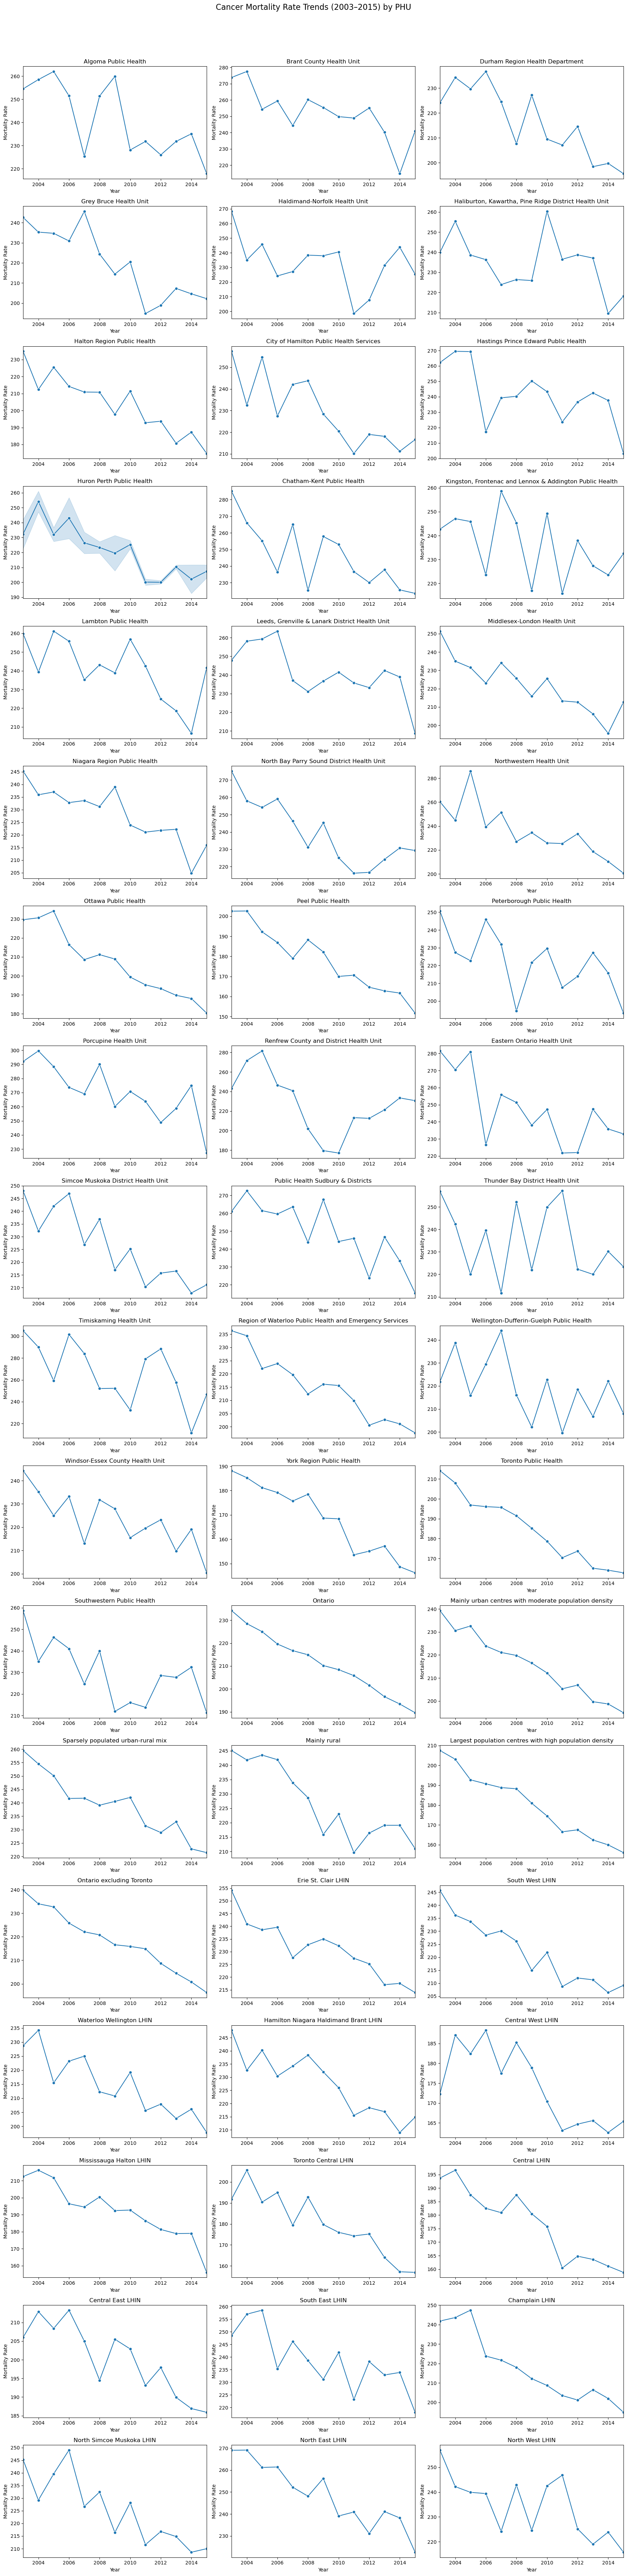

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.dates as mdates

# List of PHUs
phus = mort_filtered["PHU"].unique()
n_phus = len(phus)

# Define subplot grid
cols = 3  # number of columns per row
rows = math.ceil(n_phus / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

# Plot each PHU separately
for i, phu in enumerate(phus):
    ax = axes[i]
    phu_data = mort_filtered[mort_filtered["PHU"] == phu]
    sns.lineplot(data=phu_data, x="Year", y="MortalityRate", marker="o", ax=ax)
    ax.set_title(phu)
    ax.set_xlabel("Year")
    ax.set_ylabel("Mortality Rate")
    ax.set_xlim(2003, 2015)  # for numeric years

    
    

# Turn off unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.suptitle("Cancer Mortality Rate Trends (2003–2015) by PHU", fontsize=16, y=1.02)
plt.savefig("Cancer Mortality Rate Age_stdized rate(2003–2015) by Geography", dpi=300, bbox_inches="tight")
plt.show()




**Correlation of 2016 SDOH with Average Mortality**

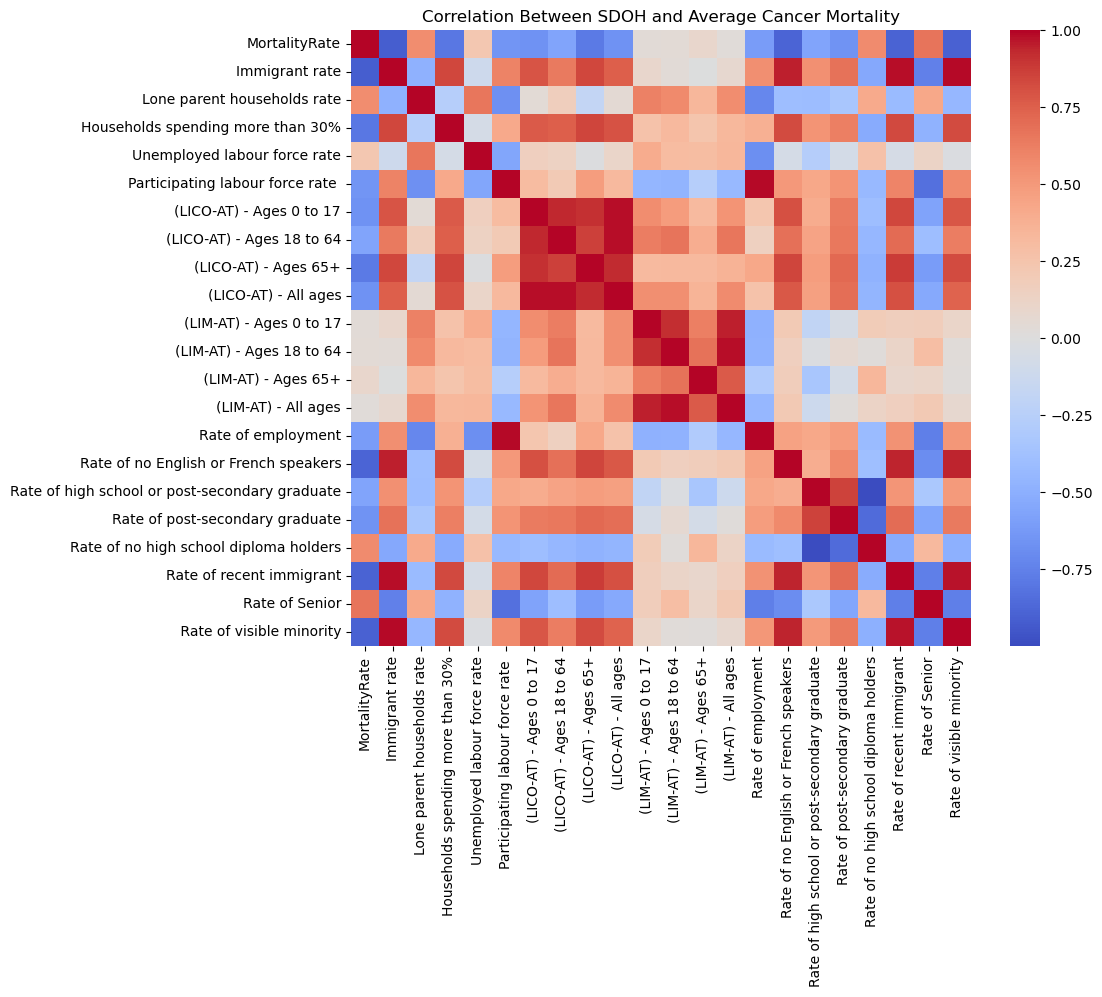

Plot saved as: Mortality_SDOH2016 Correlation


In [10]:
mort_mean = mort_filtered.groupby("PHU", as_index=False)["MortalityRate"].mean()
merged_mean = mort_mean.merge(sdoh_2016.drop(columns=['Year']), on="PHU", how="left")
corr = merged_mean.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Between SDOH and Average Cancer Mortality")
plt.savefig('Mortality_SDOH2016 Correlation', dpi=300, bbox_inches="tight")
plt.show()

print(f"Plot saved as: {'Mortality_SDOH2016 Correlation'}")

**Correlation of 2016 SDOH with Average Cancer Incidence**

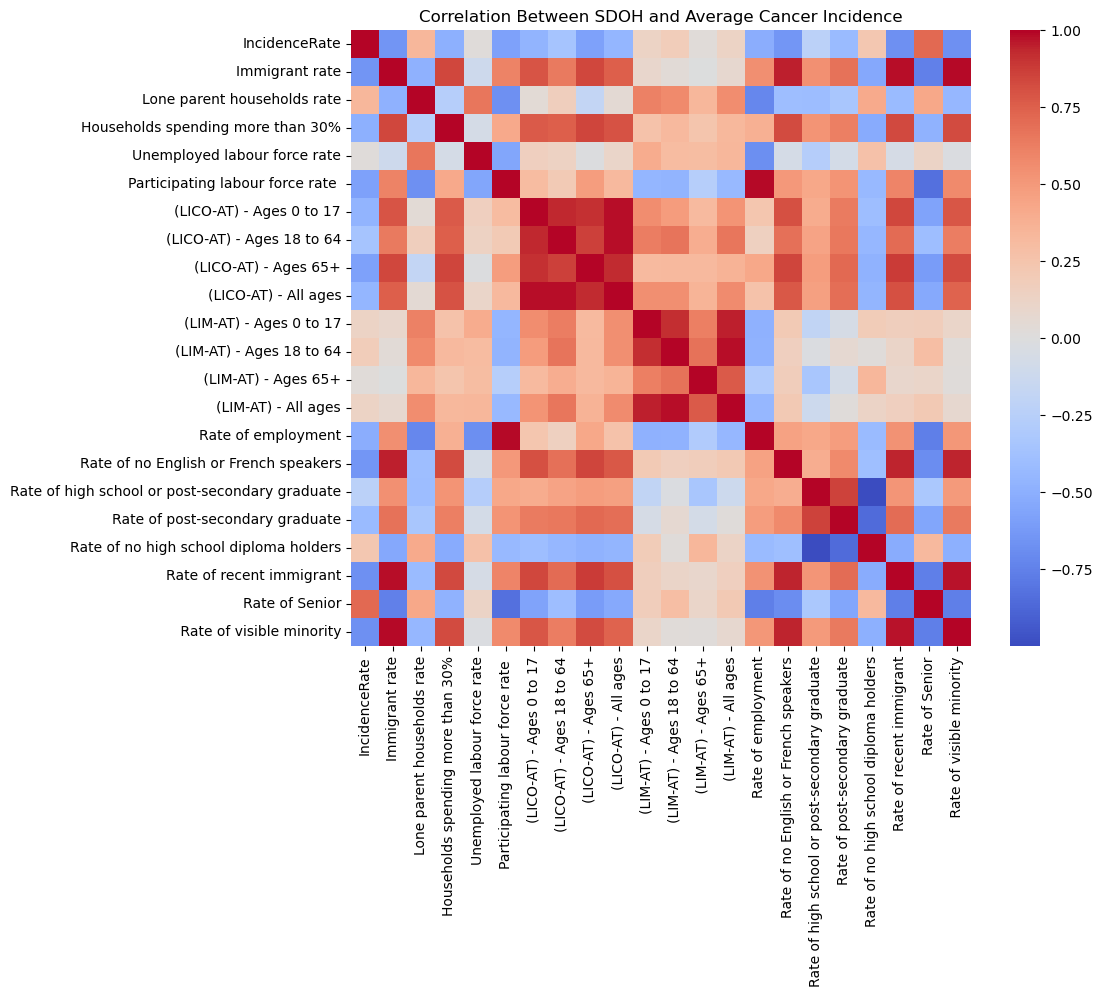

Plot saved as: Cancer Incidence_SDOH2016 Correlation


In [33]:
inc_mean = inc_filtered.groupby("PHU", as_index=False)["IncidenceRate"].mean()
inc_merged_mean = inc_mean.merge(sdoh_2016.drop(columns=['Year']), on="PHU", how="left")
corr = inc_merged_mean.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Between SDOH and Average Cancer Incidence")
plt.savefig('Cancer Incidence_SDOH2016 Correlation', dpi=300, bbox_inches="tight")
plt.show()

print(f"Plot saved as: {'Cancer Incidence_SDOH2016 Correlation'}")